# Clean Training Dataset


In [2]:
import sys

sys.path.append("../../")

In [ ]:
import ast

import pandas as pd
from scipy.spatial import distance

from climatesense_checkthat2025.utils.data import plot_variable_distribution
from climatesense_checkthat2025.utils.nlp import (
    replace_mentions,
    replace_urls,
    snake_to_titlecase,
)

## Subtask 4a Training Dataset


In [ ]:
# Load the data and convert the labels to 3 columns:
subtask4a_df = pd.read_csv("../../data/raw/task4/subtask_4a/ct_train_data.tsv", sep="\t")

# Convert the label list to 3 columns:
subtask4a_df["labels"] = subtask4a_df["labels"].apply(lambda x: ast.literal_eval(x))
subtask4a_df["scientific_claim"] = subtask4a_df["labels"].apply(lambda x: x[0])
subtask4a_df["scientific_reference"] = subtask4a_df["labels"].apply(lambda x: x[1])
subtask4a_df["scientific_entities"] = subtask4a_df["labels"].apply(lambda x: x[2])


# Remove duplicates
sel = subtask4a_df.drop_duplicates(["text", "scientific_claim", "scientific_reference", "scientific_entities"]).index
print(f"Size before: {len(subtask4a_df)} -> size after: {len(sel)}")

# Select only the row with index in sel:
subtask4a_df = subtask4a_df.loc[sel]
subtask4a_df.to_csv(
    "../../data/processed/task4/subtask_4a/ct_train_data_clean.tsv",
    sep="\t",
    index=False,
)
subtask4a_df

Size before: 1366 -> size after: 1364


,index,text,labels,scientific_claim,scientific_reference,scientific_entities
0,0,A lavender bath cause a bitch feels like shit,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
1,1,@user my.pt we will target what the end produc...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
2,2,Magnetic resonance imaging findings in giant c...,"[0.0, 1.0, 1.0]",0.0,1.0,1.0
3,3,when truth untold stops playing and the lights...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
4,4,Right wing Fascist group supports rightwing fa...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
...,...,...,...,...,...,...
1361,1361,@user if he wants to murder you. Stop by a sid...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
1362,1362,"Abah getting old, Ummi getting old. The clock ...","[0.0, 0.0, 0.0]",0.0,0.0,0.0
1363,1363,Global Expert visa: New system to keep UK 'ope...,"[0.0, 0.0, 1.0]",0.0,0.0,1.0
1364,1364,New study suggests ovarian hormone may make dr...,"[1.0, 1.0, 1.0]",1.0,1.0,1.0


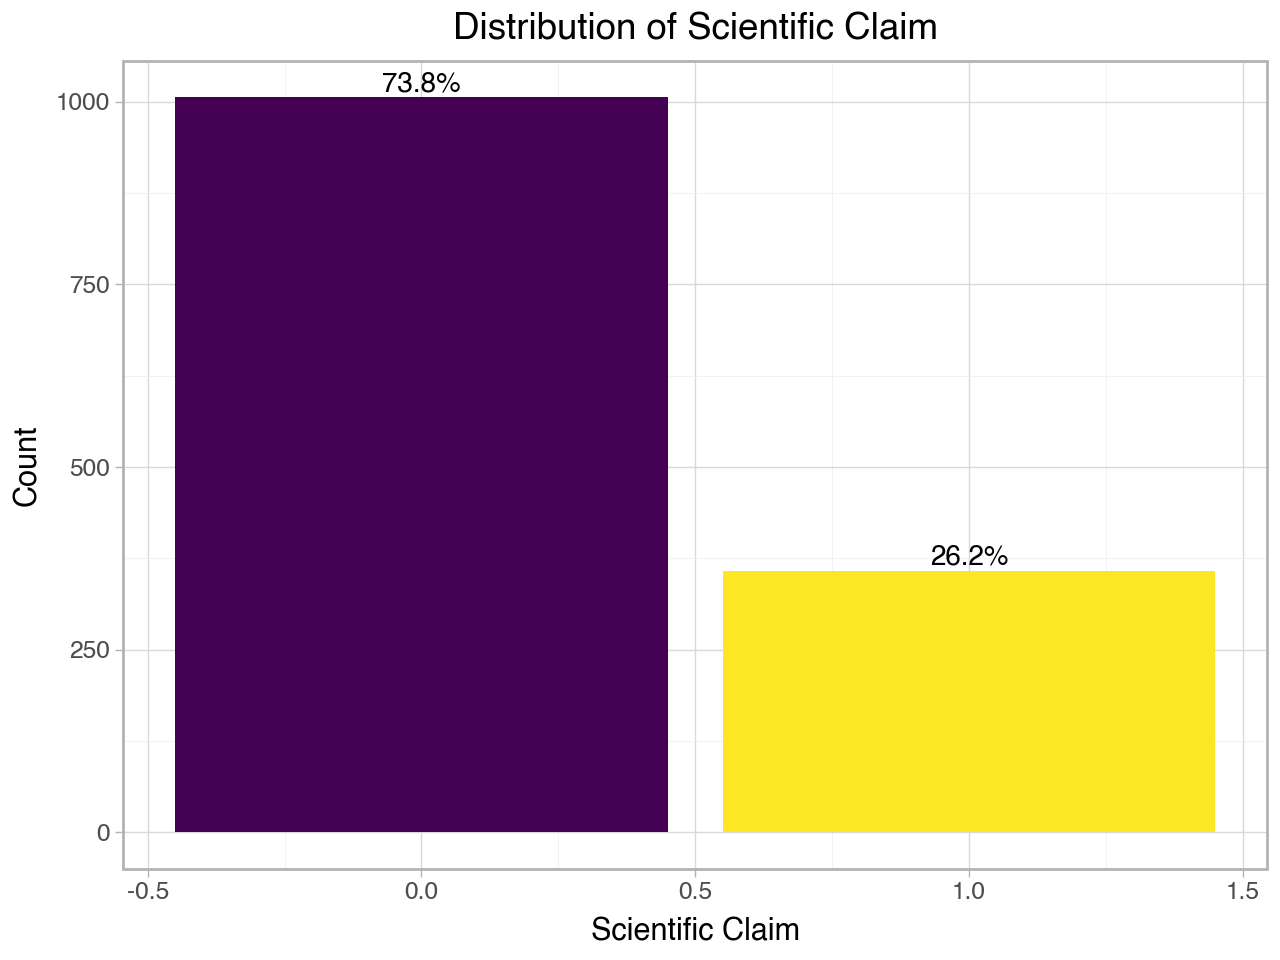

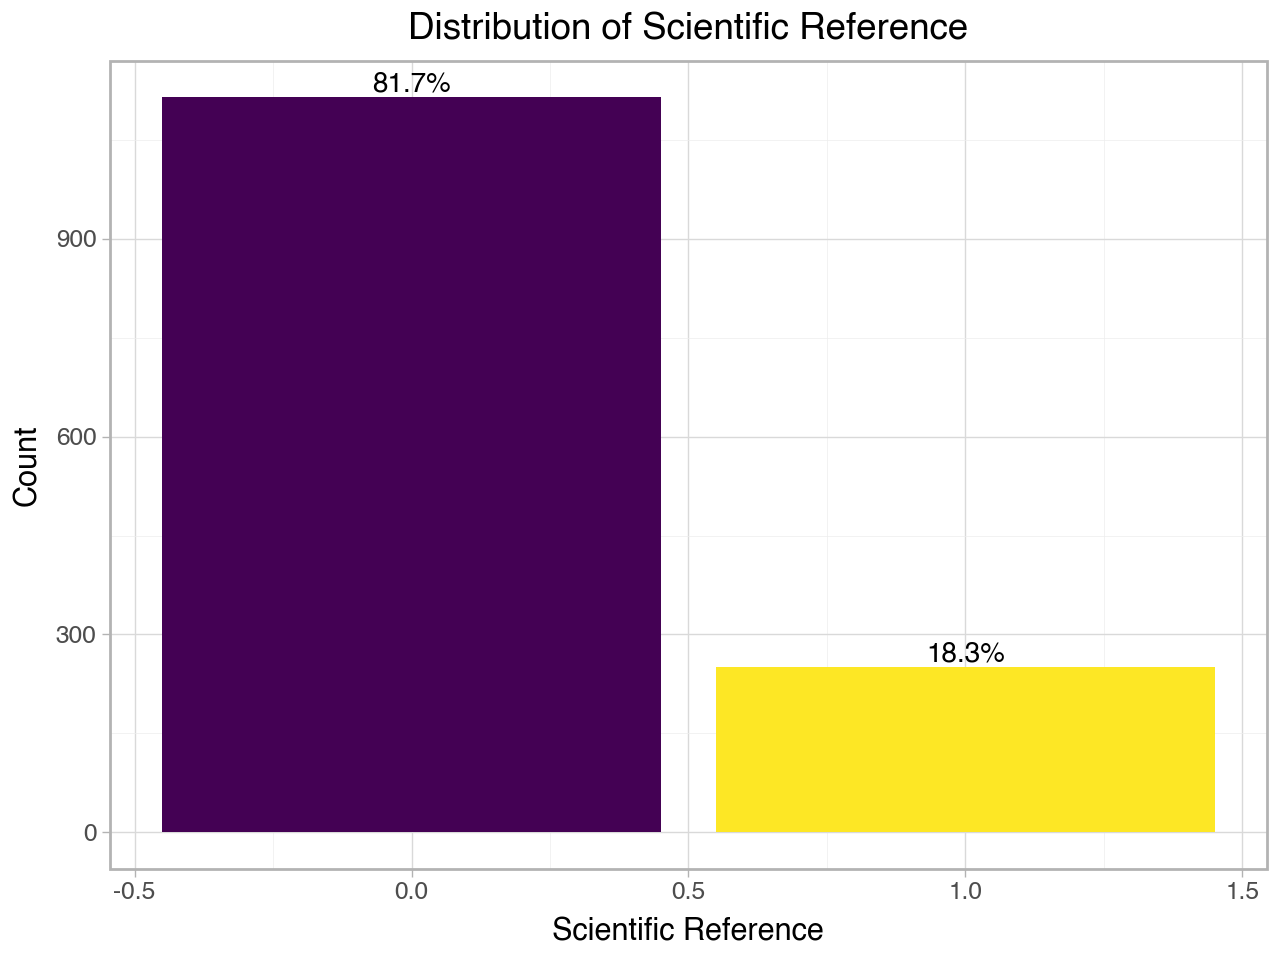

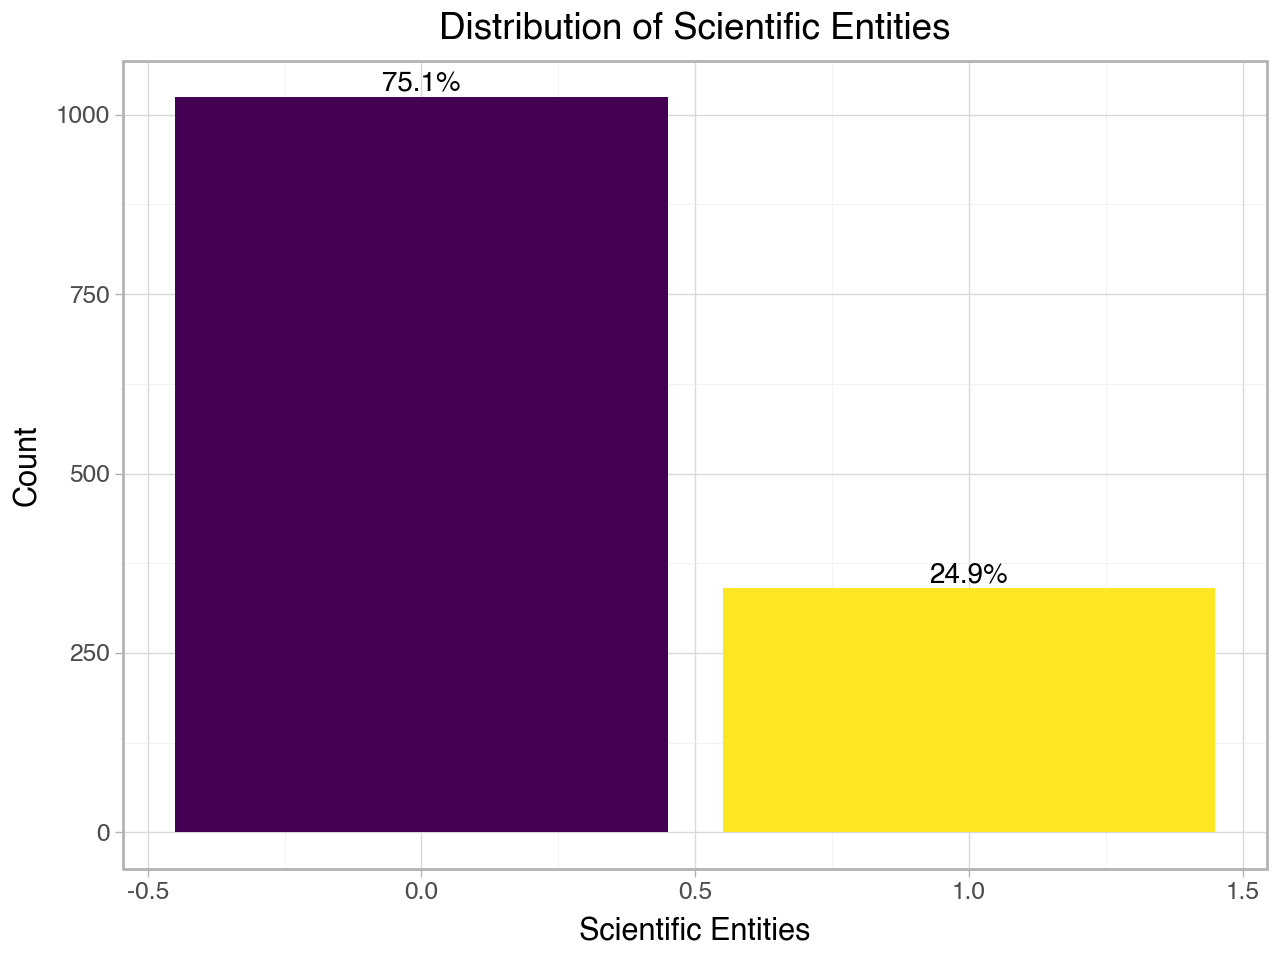

In [151]:
for i in subtask4a_df.columns[-3:]:
    plt = plot_variable_distribution(
        subtask4a_df,
        column_name=i,
        title=f"Distribution of {snake_to_titlecase(i)}",
        xlabel=snake_to_titlecase(i),
        ylabel="Count",
    )
    display(plt)

{('scientific_claim', 'scientific_reference'): np.float64(0.41620111731843573), ('scientific_claim', 'scientific_entities'): np.float64(0.48044692737430167), ('scientific_claim', ('scientific_reference', 'scientific_entities')): 0, ('scientific_reference', 'scientific_claim'): np.float64(0.596), ('scientific_reference', 'scientific_entities'): np.float64(1.0), ('scientific_reference', ('scientific_claim', 'scientific_entities')): 0, ('scientific_entities', 'scientific_claim'): np.float64(0.5058823529411764), ('scientific_entities', 'scientific_reference'): np.float64(0.7352941176470589), ('scientific_entities', ('scientific_claim', 'scientific_reference')): 0}


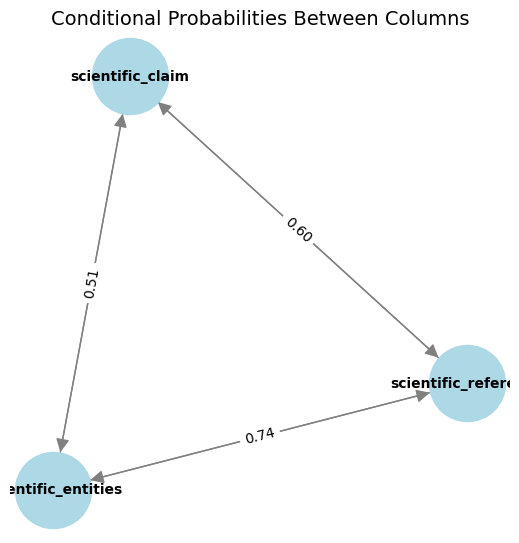

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Calculate conditional probabilities
columns = ["scientific_claim", "scientific_reference", "scientific_entities"]
probabilities = {}

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            # Probability based on individual column
            prob = (subtask4a_df.groupby([col1, col2]).size() / subtask4a_df.groupby([col1]).size()).unstack().fillna(0)
            probabilities[(col1, col2)] = prob.loc[1, 1] if 1 in prob.index and 1 in prob.columns else 0

    # Probability based on both other columns combined
    other_cols = [col for col in columns if col != col1]
    combined_prob = (subtask4a_df.groupby([col1] + other_cols).size() / subtask4a_df.groupby([col1]).size()).unstack(
        fill_value=0
    )
    probabilities[(col1, tuple(other_cols))] = (
        combined_prob.loc[1, (1, 1)] if 1 in combined_prob.index and (1, 1) in combined_prob.columns else 0
    )

print(probabilities)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges with weights
for (col1, col2), weight in probabilities.items():
    if weight > 0:
        if isinstance(col2, tuple):
            label = f"{col2[0]} & {col2[1]}"
        else:
            label = col2
        G.add_edge(col1, label, weight=weight)

# Draw the graph
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, "weight")

plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G)  # Use spring layout for better spacing
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    edge_color="gray",
    arrowsize=20,
)
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()}, font_size=10)
plt.title("Conditional Probabilities Between Columns", fontsize=14)
plt.show()

In [ ]:
probabilities

{('scientific_claim', 'scientific_reference'): np.float64(0.41620111731843573),
 ('scientific_claim', 'scientific_entities'): np.float64(0.48044692737430167),
 ('scientific_claim', ('scientific_reference', 'scientific_entities')): 0,
 ('scientific_reference', 'scientific_claim'): np.float64(0.596),
 ('scientific_reference', 'scientific_entities'): np.float64(1.0),
 ('scientific_reference', ('scientific_claim', 'scientific_entities')): 0,
 ('scientific_entities', 'scientific_claim'): np.float64(0.5058823529411764),
 ('scientific_entities',
  'scientific_reference'): np.float64(0.7352941176470589),
 ('scientific_entities', ('scientific_claim', 'scientific_reference')): 0}

## SciTweet dataset

How different is the data when compared to the SciTweet dataset?


In [ ]:
scitweets_df = pd.read_csv("../../data/raw/task4/scitweets/scitweets_annotations.tsv", sep="\t")[
    [
        "text",
        "processed_urls",
        "cat1_final_answer",
        "cat2_final_answer",
        "cat3_final_answer",
    ]  # See https://github.com/AI-4-Sci/SciTweets/blob/main/annotation_framework.pdf
]
scitweets_df = scitweets_df.rename(
    columns={
        "cat1_final_answer": "scientific_claim",
        "cat2_final_answer": "scientific_reference",
        "cat3_final_answer": "scientific_entities",
    }
)
# Apply the function to replace URLs in the 'text' column using 'processed_urls' and replace mentions:
scitweets_df["text"] = scitweets_df.apply(
    lambda row: replace_mentions(replace_urls(row["text"], ast.literal_eval(row["processed_urls"]))),
    axis=1,
)

# Drop the rows that have values different from 0.0 and 1.1:
print(f"Before: {len(scitweets_df)} -> after: {len(scitweets_df[~scitweets_df.iloc[:, -3:].isin([0.5]).any(axis=1)])}")
scitweets_df = scitweets_df[~scitweets_df.iloc[:, -3:].isin([0.5]).any(axis=1)]

scitweets_df = scitweets_df.drop("processed_urls", axis=1)
scitweets_df.to_csv("../../data/processed/task4/subtask_4a/scitweets_data.tsv", sep="\t", index=False)
scitweets_df

Before: 1261 -> after: 1140


,text,scientific_claim,scientific_reference,scientific_entities
0,Knees are a bit sore. i guess that's a sign th...,0.0,0.0,0.0
1,McDonald's breakfast stop then the gym 🏀💪,0.0,0.0,0.0
2,Can any Gynecologist with Cancer Experience ex...,1.0,0.0,0.0
3,Couch-lock highs lead to sleeping in the couch...,1.0,0.0,0.0
4,Does daily routine help prevent problems with ...,1.0,0.0,0.0
...,...,...,...,...
1255,@user @user I'm sorry but we DO NOT have 1/4 o...,1.0,0.0,0.0
1256,"Dear #NIN applicants, you can kindly download ...",0.0,0.0,0.0
1258,Whats the uber support team email address?,0.0,0.0,0.0
1259,House passes bill to increase stimulus checks ...,0.0,0.0,0.0


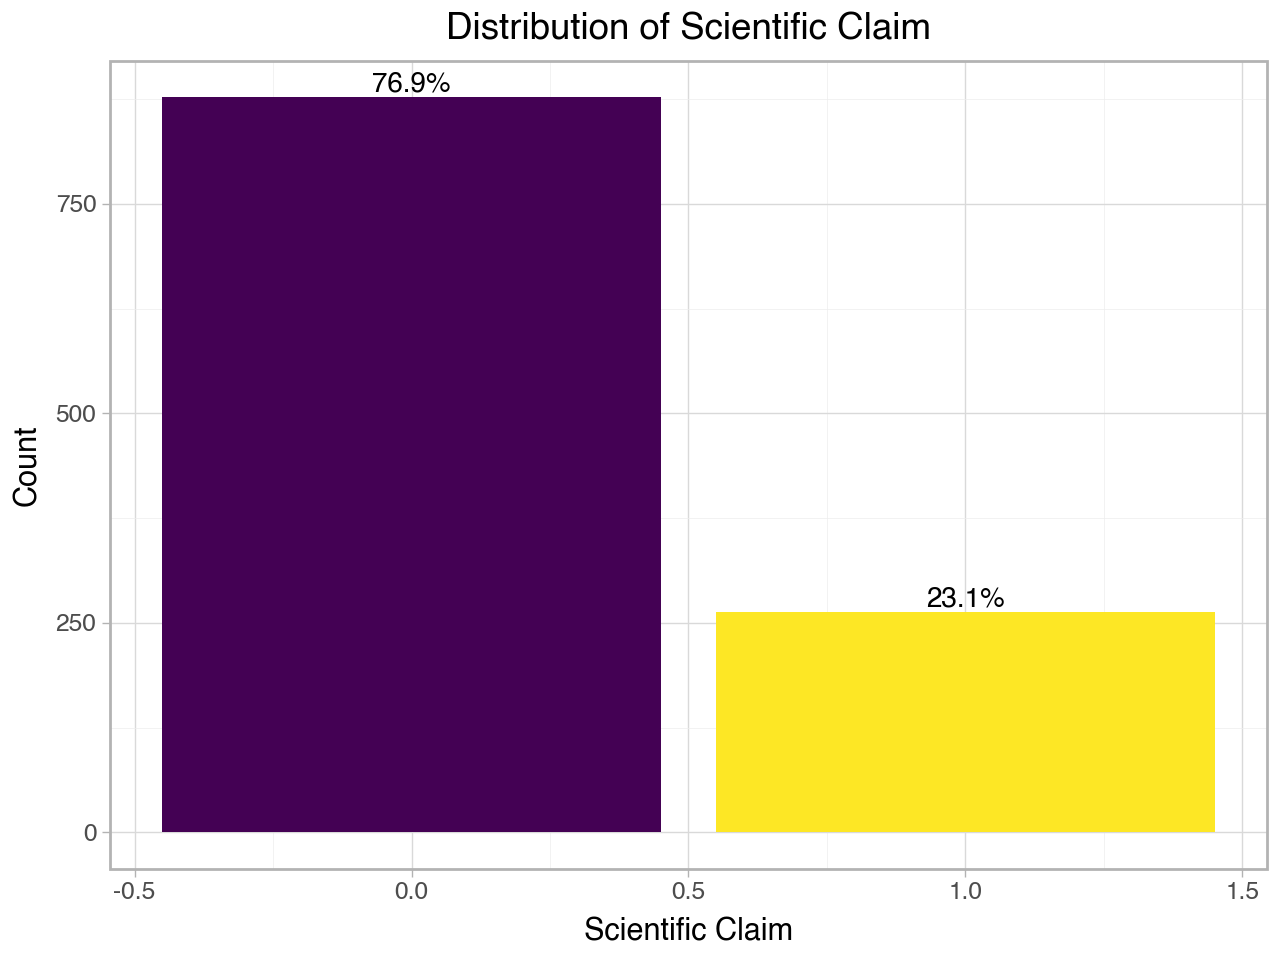

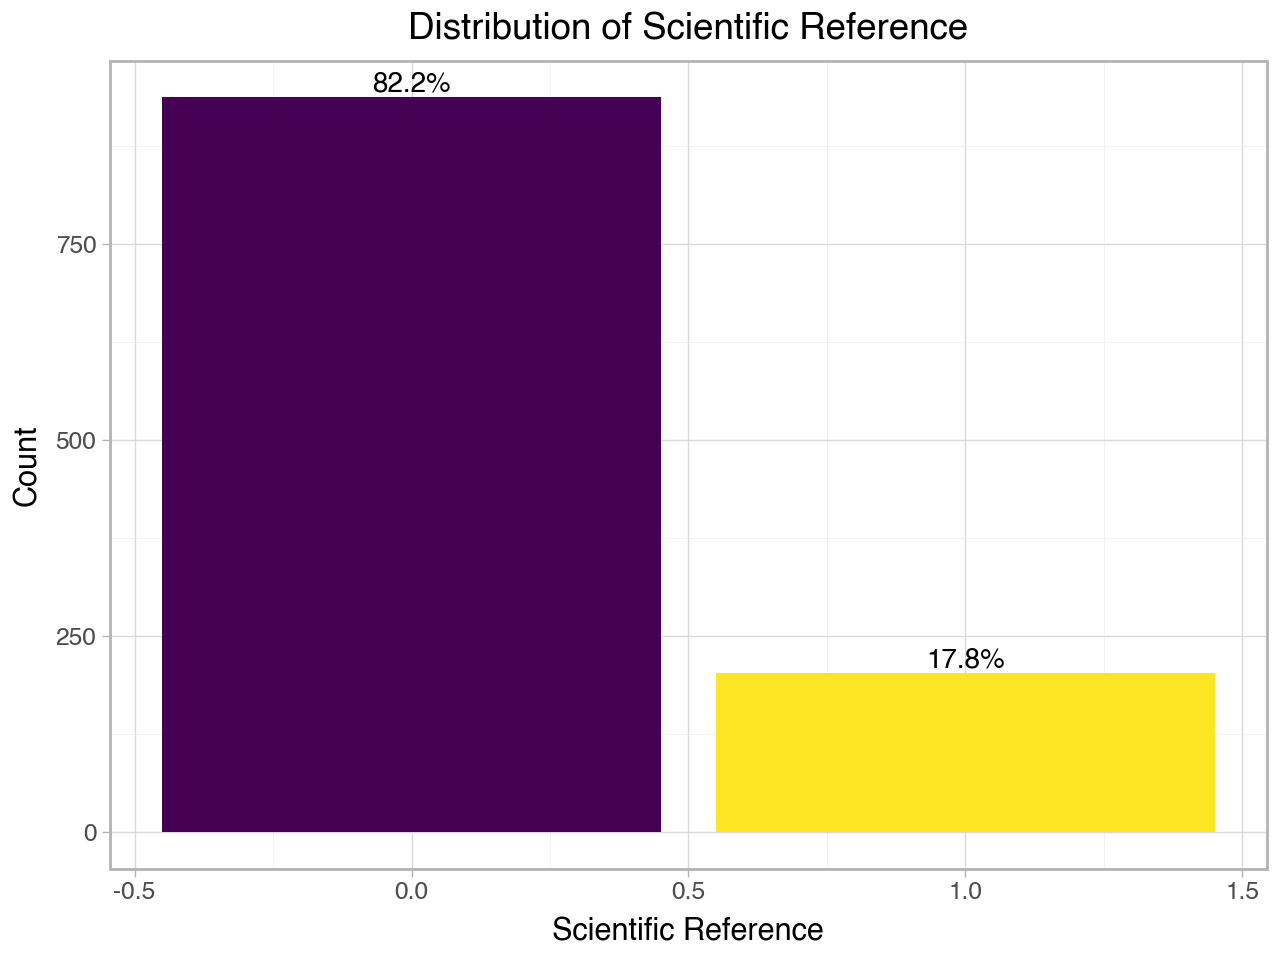

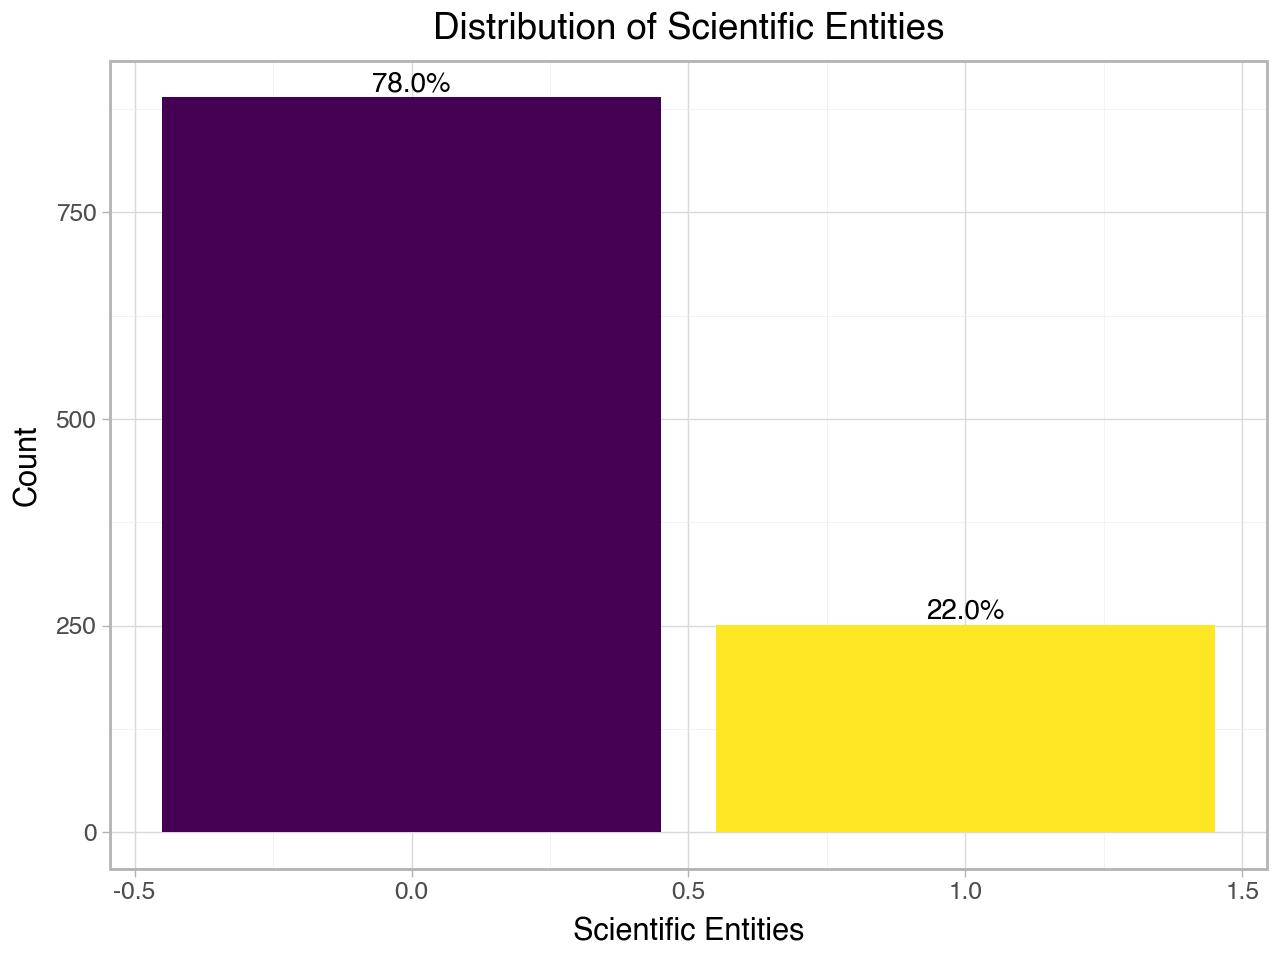

In [96]:
for i in scitweets_df.columns[-3:]:
    plt = plot_variable_distribution(
        scitweets_df,
        column_name=i,
        title=f"Distribution of {snake_to_titlecase(i)}",
        xlabel=snake_to_titlecase(i),
        ylabel="Count",
    )
    display(plt)

## SciWebClaims Dataset

Task 2 is not relevant to the SciWebClaims dataset. The dataset is not maide of X posts.


In [ ]:
sciwebclaims_df = pd.concat(
    [
        pd.read_csv("../../data/raw/task4/sciwebclaims/consolidated_task1.tsv", sep="\t")[
            ["claim", "scientific_claim"]
        ],
        pd.read_csv("../../data/raw/task4/sciwebclaims/consolidated_task3.tsv", sep="\t")[
            ["claim", "scientific_claim"]
        ],
    ]
).drop_duplicates()

sciwebclaims_df = sciwebclaims_df.rename(columns={"claim": "text"})
sciwebclaims_df["scientific_claim"] = sciwebclaims_df.scientific_claim.astype(float)

sciwebclaims_df.to_csv("../../data/processed/task4/subtask_4a/sciwebclaims_data.tsv", sep="\t", index=False)
sciwebclaims_df

,text,scientific_claim
0,Big oil asks government to protect its Texas f...,0.0
1,Why is climate change a global problem? https:...,1.0
2,How can greenhouse gases be removed from the a...,1.0
3,Paris Agreement 2015/Art.2.1(c): Making financ...,0.0
4,I just cast my ballot for: ✅Equality ✅Women’s ...,0.0
...,...,...
430,"Dissociative identity disorder, or DID, may ca...",1.0
431,Dark matter is a different color than dark ene...,1.0
432,Personality is affected by the development of ...,0.0
433,Parkinson's disease causes akinesia.,1.0


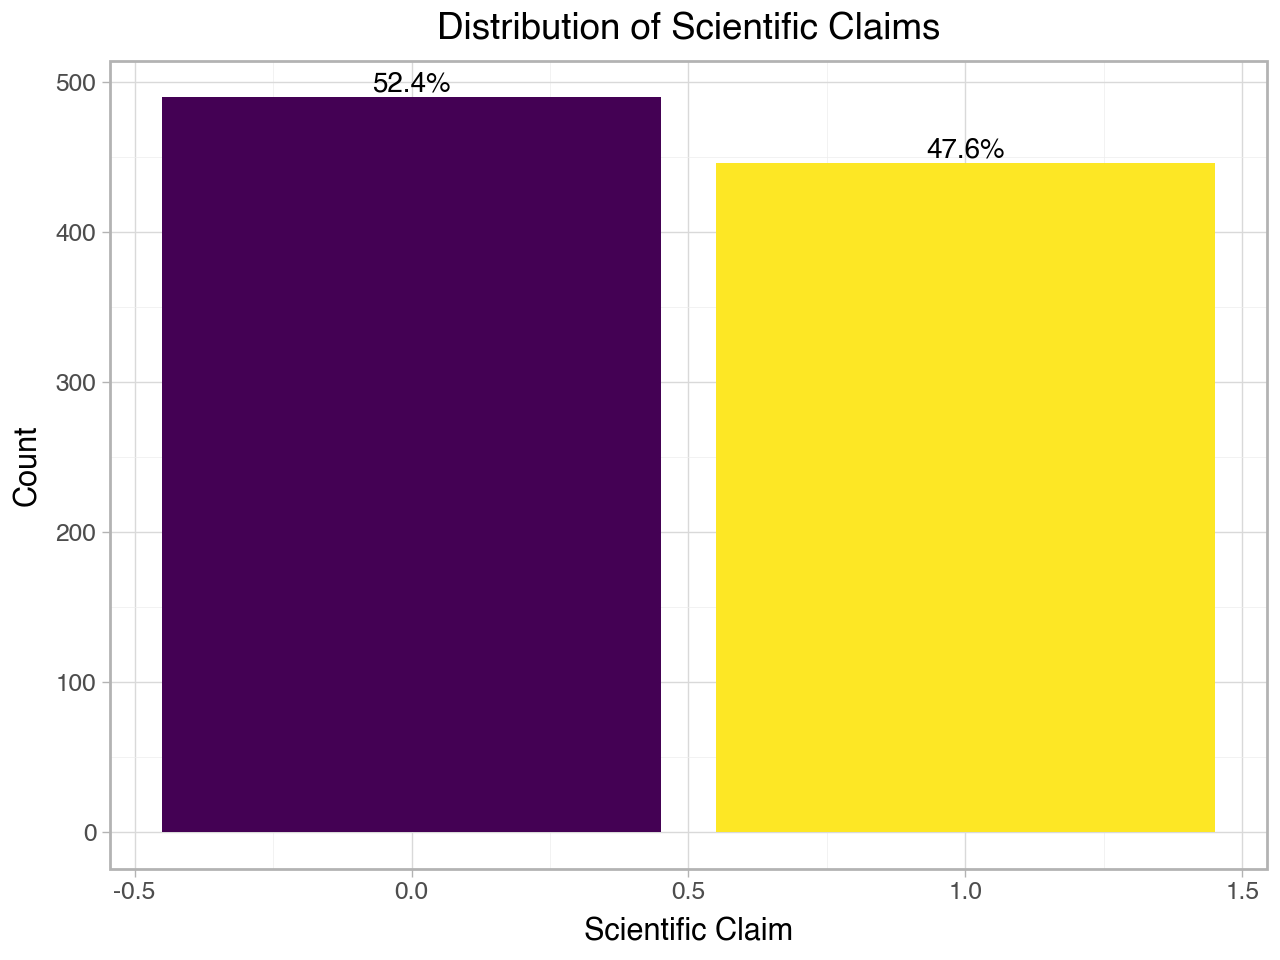

In [98]:
plot_variable_distribution(
    sciwebclaims_df,
    column_name="scientific_claim",
    title="Distribution of Scientific Claims",
    xlabel="Scientific Claim",
    ylabel="Count",
)

## Claims/Text Comparison

How similar are the datasets?


In [ ]:
from sentence_transformers import SentenceTransformer

# Based on MMTEB: Massive Multilingual Text Embedding Benchmark
# model = SentenceTransformer("all-MiniLM-L6-v2") # The classic model
model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-1.5B-instruct")  # The best model that is not too big.
# TODO Check BAI / AliBaba models https://github.com/FlagOpen/FlagEmbedding bge-m3

subtask4a_emb = model.encode(subtask4a_df.text.values, normalize_embeddings=True, show_progress_bar=True)
scitweets_emb = model.encode(scitweets_df.text.values, normalize_embeddings=True, show_progress_bar=True)
sciwebclaims_emb = model.encode(sciwebclaims_df.text.values, normalize_embeddings=True, show_progress_bar=True)

In [ ]:
similarities1 = model.similarity(subtask4a_emb, scitweets_emb)
similarities2 = model.similarity(subtask4a_emb, sciwebclaims_emb)
similarities3 = model.similarity(scitweets_emb, sciwebclaims_emb)  # Compare the additional datasets.

In [ ]:
similarities_df1 = pd.DataFrame(similarities1.numpy())
similarities_df1 = pd.DataFrame(
    {
        "scitweets_idx": similarities_df1.idxmax(axis=1),
        "similarity": similarities_df1.max(axis=1),
    }
)

similarities_df1[similarities_df1.similarity >= 0.8]

print(f"Original: {len(similarities_df1)} <-> Similar: {len(similarities_df1[similarities_df1.similarity >= 0.8])}")

Original: 1364 <-> Similar: 804


In [ ]:
similarities_df2 = pd.DataFrame(similarities2.numpy())
similarities_df2 = pd.DataFrame(
    {
        "sciwebclaims_idx": similarities_df2.idxmax(axis=1),
        "similarity": similarities_df2.max(axis=1),
    }
)

similarities_df2[similarities_df2.similarity >= 0.8]

print(f"Original: {len(similarities_df2)} <-> Similar: {len(similarities_df2[similarities_df2.similarity >= 0.8])}")

Original: 1364 <-> Similar: 5


In [ ]:
similarities_df3 = pd.DataFrame(similarities3.numpy())
similarities_df3 = pd.DataFrame(
    {
        "scitweets_idx": similarities_df3.idxmax(axis=1),
        "similarity": similarities_df3.max(axis=1),
    }
)

similarities_df3[similarities_df3.similarity >= 0.8]

print(f"Original: {len(similarities_df3)} <-> Similar: {len(similarities_df3[similarities_df3.similarity >= 0.8])}")

Original: 1140 <-> Similar: 65


In [ ]:
# Compare the annotations for teh first 2 datasets are they are similar:
# subtask4a_df
similarities_df1b = similarities_df1
similarities_df1b["text"] = subtask4a_df["text"]
similarities_df1b["scientific_claim"] = subtask4a_df["scientific_claim"]
similarities_df1b["scientific_reference"] = subtask4a_df["scientific_reference"]
similarities_df1b["scientific_entities"] = subtask4a_df["scientific_entities"]
scitweets_df["id"] = range(0, len(scitweets_df))  # index does not work but ranges does.

similarities_df1b = similarities_df1b.merge(scitweets_df, left_on="scitweets_idx", right_on="id", how="left")
similarities_df1b = similarities_df1b[similarities_df1b.similarity >= 0.8]  # .to_clipboard()

In [134]:
similarities_df1b

,scitweets_idx,similarity,text_x,scientific_claim_x,scientific_reference_x,scientific_entities_x,text_y,scientific_claim_y,scientific_reference_y,scientific_entities_y,id
0,931,1.000000,A lavender bath cause a bitch feels like shit,0.0,0.0,0.0,A lavender bath cause a bitch feels like shit,0.0,0.0,0.0,931
1,428,1.000000,@user my.pt we will target what the end produc...,0.0,0.0,0.0,@user my.pt we will target what the end produc...,0.0,0.0,0.0,428
2,388,0.993708,Magnetic resonance imaging findings in giant c...,0.0,1.0,1.0,Magnetic resonance imaging findings in giant c...,0.0,1.0,1.0,388
5,65,1.000001,Who Is Cindy Starfall Promote Cindy Starfall h...,0.0,0.0,0.0,Who Is Cindy Starfall Promote Cindy Starfall h...,0.0,0.0,0.0,65
8,251,0.913602,In @user: Rare variant found that raises HDL c...,1.0,1.0,1.0,"“Overzealous, dangerous patriotism”: School nu...",0.0,0.0,0.0,251
...,...,...,...,...,...,...,...,...,...,...,...
1357,854,0.992058,Also reports of severe flooding on Weber Stree...,0.0,0.0,0.0,Please Watch & share this powerful TEDx talk b...,1.0,0.0,0.0,854
1358,770,1.000000,@user Tell Fulani settlers to STOP intimidatin...,0.0,0.0,0.0,Babies cannot speak so parents never know the ...,1.0,0.0,0.0,770
1359,336,1.000000,Please Watch &amp; share this powerful TEDx ta...,1.0,0.0,0.0,@user if he wants to murder you. Stop by a sid...,0.0,0.0,0.0,336
1360,1055,1.000000,Babies cannot speak so parents never know the ...,1.0,0.0,0.0,"Abah getting old, Ummi getting old. The clock ...",0.0,0.0,0.0,1055


In [ ]:
similarities_df1b["jaccard_distance"] = similarities_df1b.apply(
    lambda row: 1
    - distance.jaccard(
        row[["scientific_claim_x", "scientific_reference_x", "scientific_entities_x"]],
        row[["scientific_claim_y", "scientific_reference_y", "scientific_entities_y"]],
    ),
    axis=1,
)

# There result actully appear to be the same but the error seems to be due to not using a re-ranker model.
similarities_df1b["jaccard_distance"].mean()

np.float64(0.6015754560530681)

In [ ]:
# Save the diff datasets:
scitweets_df["sim_id"] = range(0, len(scitweets_df))
scitweets_df[
    scitweets_df["sim_id"].isin(similarities_df1[similarities_df1.similarity < 0.8].scitweets_idx.values)
].drop(columns=["sim_id", "id"]).to_csv(
    "../../data/processed/task4/subtask_4a/scitweets_data_clean.tsv",
    sep="\t",
    index=False,
)

In [ ]:
# Save the diff datasets: (the sciwebclaim only work for the first label)
sciwebclaims_df["sim_id"] = range(0, len(sciwebclaims_df))
sciwebclaims_df[
    sciwebclaims_df["sim_id"].isin(similarities_df2[similarities_df2.similarity < 0.8].sciwebclaims_idx.values)
].drop(columns=["sim_id"]).to_csv(
    "../../data/processed/task4/subtask_4a/sciwebclaims_data_clean.tsv",
    sep="\t",
    index=False,
)

# Check 0/0/0

Check the number of cases where there are no scientific content.
If there are many cases, it may be a good idea to create a separate classifier for detecting such a case.

It seems that a lot of cases are  0/0/0. Therefore we should probably only train on != 0/0/0 cases and use a separate classifier for 0/0/0 cases.


In [6]:
ct_train_data_clean_df = pd.read_csv("../../data/processed/task4/subtask_4a/ct_train_data_clean.tsv", sep="\t")
ct_train_data_clean_df

,index,text,labels,scientific_claim,scientific_reference,scientific_entities
0,0,A lavender bath cause a bitch feels like shit,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
1,1,@user my.pt we will target what the end produc...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
2,2,Magnetic resonance imaging findings in giant c...,"[0.0, 1.0, 1.0]",0.0,1.0,1.0
3,3,when truth untold stops playing and the lights...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
4,4,Right wing Fascist group supports rightwing fa...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
...,...,...,...,...,...,...
1359,1361,@user if he wants to murder you. Stop by a sid...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
1360,1362,"Abah getting old, Ummi getting old. The clock ...","[0.0, 0.0, 0.0]",0.0,0.0,0.0
1361,1363,Global Expert visa: New system to keep UK 'ope...,"[0.0, 0.0, 1.0]",0.0,0.0,1.0
1362,1364,New study suggests ovarian hormone may make dr...,"[1.0, 1.0, 1.0]",1.0,1.0,1.0


In [ ]:
# For each row check if scientific_claim, scientific_reference,	scientific_entities are all 0.0:
def check_all_zero(row):
    return all(value == 0.0 for value in row[["scientific_claim", "scientific_reference", "scientific_entities"]])


ct_train_data_clean_df["all_zero"] = ct_train_data_clean_df.apply(check_all_zero, axis=1)


# Or all 1.0:
def check_all_one(row):
    return all(value == 1.0 for value in row[["scientific_claim", "scientific_reference", "scientific_entities"]])


ct_train_data_clean_df["all_one"] = ct_train_data_clean_df.apply(check_all_one, axis=1)


ct_train_data_clean_df

,index,text,labels,scientific_claim,scientific_reference,scientific_entities,all_zero,all_one
0,0,A lavender bath cause a bitch feels like shit,"[0.0, 0.0, 0.0]",0.0,0.0,0.0,True,False
1,1,@user my.pt we will target what the end produc...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0,True,False
2,2,Magnetic resonance imaging findings in giant c...,"[0.0, 1.0, 1.0]",0.0,1.0,1.0,False,False
3,3,when truth untold stops playing and the lights...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0,True,False
4,4,Right wing Fascist group supports rightwing fa...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0,True,False
...,...,...,...,...,...,...,...,...
1359,1361,@user if he wants to murder you. Stop by a sid...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0,True,False
1360,1362,"Abah getting old, Ummi getting old. The clock ...","[0.0, 0.0, 0.0]",0.0,0.0,0.0,True,False
1361,1363,Global Expert visa: New system to keep UK 'ope...,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,False,False
1362,1364,New study suggests ovarian hormone may make dr...,"[1.0, 1.0, 1.0]",1.0,1.0,1.0,False,True


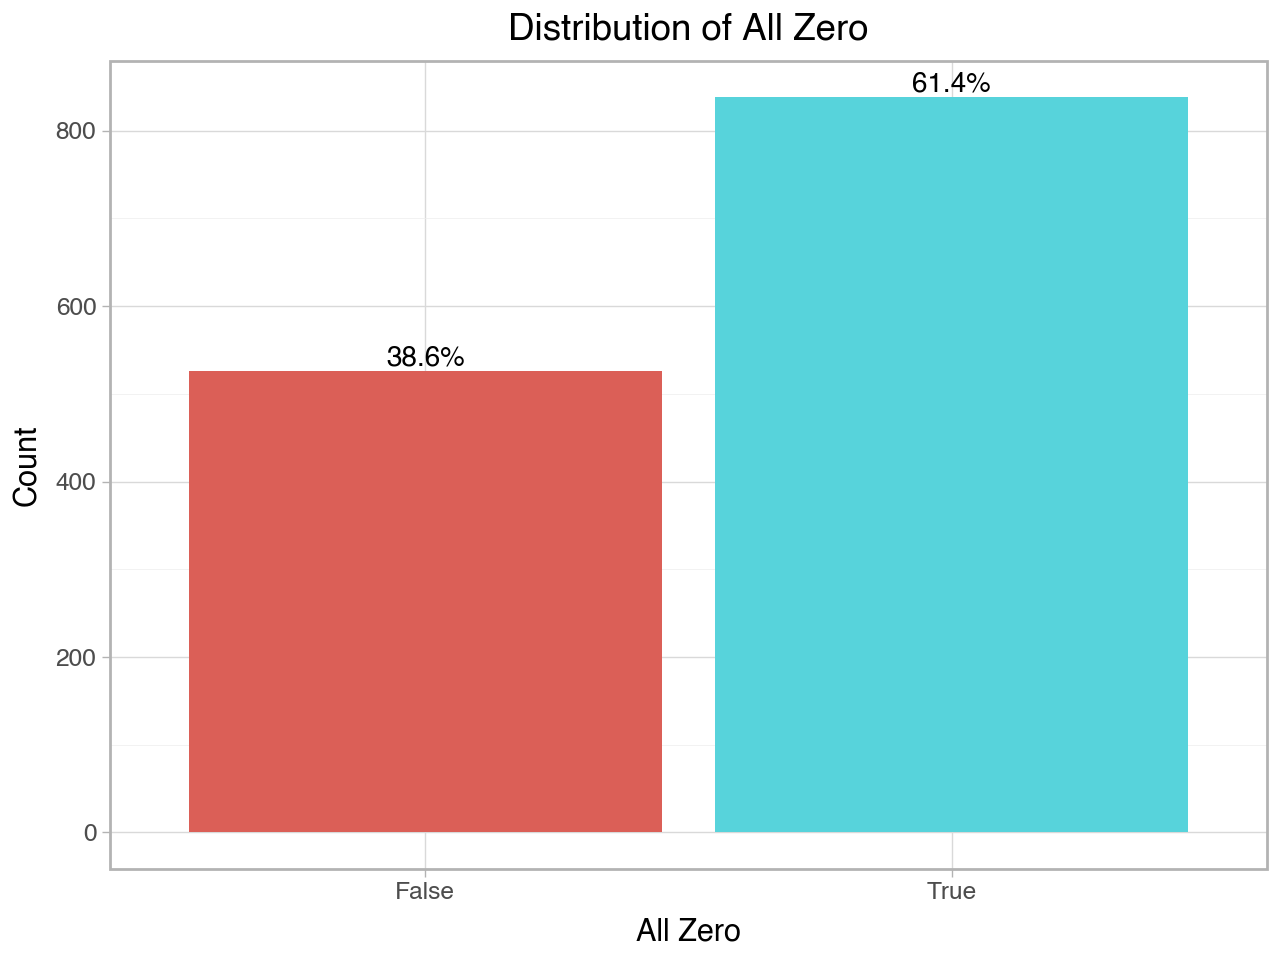

In [15]:
pt = plot_variable_distribution(
    ct_train_data_clean_df,
    column_name="all_zero",
    title="Distribution of All Zero",
    xlabel="All Zero",
    ylabel="Count",
)
display(pt)

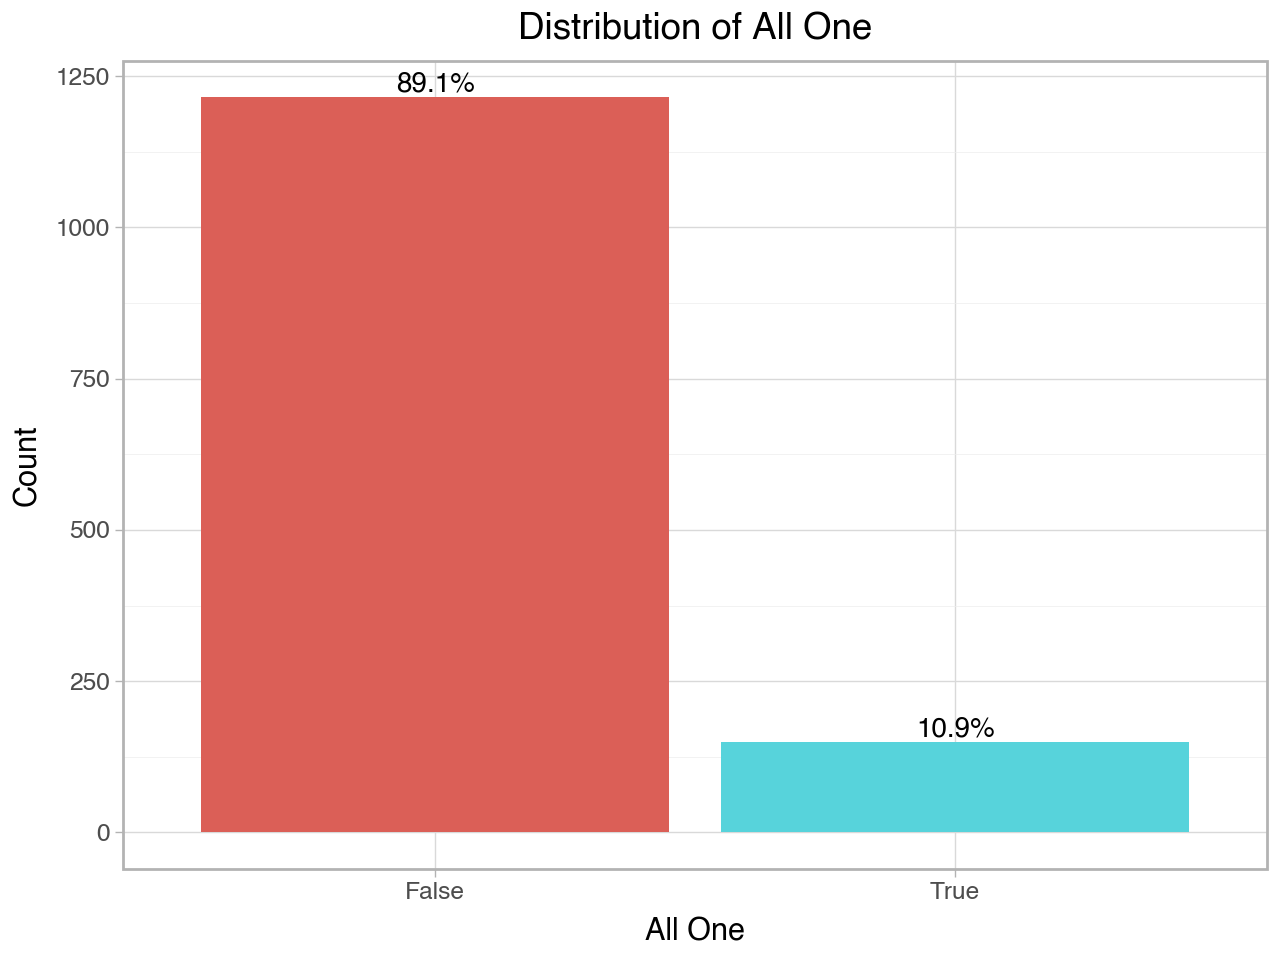

In [14]:
pt = plot_variable_distribution(
    ct_train_data_clean_df,
    column_name="all_one",
    title="Distribution of All One",
    xlabel="All One",
    ylabel="Count",
)
display(pt)

## Create Dataset for the Train/Dev Sets:


In [ ]:
# Load the data and convert the labels to 3 columns:
subtask4a_train_df = pd.read_csv("../../data/raw/task4/subtask_4a/ct_train.tsv", sep="\t")


# Convert the label list to 3 columns:
subtask4a_train_df["labels"] = subtask4a_train_df["labels"].apply(lambda x: ast.literal_eval(x))
subtask4a_train_df["scientific_claim"] = subtask4a_train_df["labels"].apply(lambda x: x[0])
subtask4a_train_df["scientific_reference"] = subtask4a_train_df["labels"].apply(lambda x: x[1])
subtask4a_train_df["scientific_entities"] = subtask4a_train_df["labels"].apply(lambda x: x[2])


# Remove duplicates
sel = subtask4a_train_df.drop_duplicates(
    ["text", "scientific_claim", "scientific_reference", "scientific_entities"]
).index
print(f"Size before: {len(subtask4a_train_df)} -> size after: {len(sel)}")

# Select only the row with index in sel:
subtask4a_train_df = subtask4a_train_df.loc[sel]
subtask4a_train_df.to_csv("../../data/processed/task4/subtask_4a/ct_train_clean.tsv", sep="\t", index=False)
subtask4a_train_df

Size before: 1229 -> size after: 1228


,index,text,labels,scientific_claim,scientific_reference,scientific_entities
0,1046,@user those eyes are a gift send straight from...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
1,638,Remember when libs attacked @user for his conc...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
2,1091,Teenage Fever is a mood,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
3,31,Steam survey shows PC gamers are still mostly ...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
4,142,Key findings utilized by Watson and Crick: Fra...,"[0.0, 0.0, 1.0]",0.0,0.0,1.0
...,...,...,...,...,...,...
1224,296,"Hey everyone, here's a great thing from @user ...","[0.0, 0.0, 0.0]",0.0,0.0,0.0
1225,94,The War On Science: What It Is And How To Win ...,"[0.0, 0.0, 1.0]",0.0,0.0,1.0
1226,1240,https://tonic.vice.com/en_us/article/8xz9mz/ma...,"[1.0, 1.0, 1.0]",1.0,1.0,1.0
1227,637,@user Martha - stop the redundant BS!! Even if...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0


In [ ]:
# We do not remove duplicates in the decv:
subtask4a_dev_df = pd.read_csv("../../data/raw/task4/subtask_4a/ct_dev.tsv", sep="\t")


# Convert the label list to 3 columns:
subtask4a_dev_df["labels"] = subtask4a_dev_df["labels"].apply(lambda x: ast.literal_eval(x))
subtask4a_dev_df["scientific_claim"] = subtask4a_dev_df["labels"].apply(lambda x: x[0])
subtask4a_dev_df["scientific_reference"] = subtask4a_dev_df["labels"].apply(lambda x: x[1])
subtask4a_dev_df["scientific_entities"] = subtask4a_dev_df["labels"].apply(lambda x: x[2])

subtask4a_dev_df.to_csv("../../data/processed/task4/subtask_4a/ct_dev_clean.tsv", sep="\t", index=False)
subtask4a_dev_df

,index,text,labels,scientific_claim,scientific_reference,scientific_entities
0,11,@user Nabil these sickos full stop preying on ...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
1,23,So do strippers just wait to be saved to stop ...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
2,28,The weaponization of medical language embolden...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
3,32,#sports #fitness Buy Now: $33.97 Ueasy Knee pa...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
4,57,@user thx for support also trans community - a...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
...,...,...,...,...,...,...
132,1317,Winter Tipples tasting went down a treat last ...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
133,1327,@user Please read this research analysis https...,"[0.0, 1.0, 1.0]",0.0,1.0,1.0
134,1329,@user Stop hoarding so much and throw some shi...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0
135,1343,@user ugh. I'm really over the mezzo drama. th...,"[0.0, 0.0, 0.0]",0.0,0.0,0.0


In [ ]:
# We do not remove duplicates in the eval:
subtask4a_eval_df = pd.read_csv("../../data/raw/task4/subtask_4a/ct_test.tsv", sep="\t")
subtask4a_eval_df.to_csv("../../data/processed/task4/subtask_4a/ct_eval_clean.tsv", sep="\t", index=False)
subtask4a_eval_df

,index,text
0,t_0,'That's because if a broadband provider inform...
1,t_1,"Prostate biopsy - adenocarcinoma, high-grade t..."
2,t_2,Unwise policy that harms the environment and b...
3,t_3,"""@user My main worry is that—in the era of swi..."
4,t_4,I'm excited to introduce Bioicons - a comprehe...
...,...,...
235,t_235,"@user Oddly enough, I believe the research— po..."
236,t_236,Research indicates that reading the Harry Pott...
237,t_237,Are Female Leaders More Effective Than Males? ...
238,t_238,Parents spending a significant portion of thei...
